In [6]:
import tensorflow as tf
import numpy as np
import math
import glob
import matplotlib

import matplotlib.pyplot as plt
from matplotlib.pyplot import plot,savefig
from dataset import *

from sklearn.datasets import load_iris
import xgboost as xgb
import sklearn as sk
from xgboost import plot_importance
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.decomposition import PCA
import mylib as ml2
from mylib import LiftNet, create_LiftNet, create_Standard_LiftNet, Standard_LiftNet

from plotly.graph_objs import Scatter,Layout
import plotly
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.subplots import make_subplots
import pandas as pd
import plotly.figure_factory as ff

#setting offilne
plotly.offline.init_notebook_mode(connected=True)

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [7]:
#---------liftnet parameter------#
test_rate = 0.2
epochs = 10000
lr=0.015
momentum=0.8
decay=0.01
validation_split=0.2
steps_per_epoch=1
validation_steps=1

cutsize = 256
#head_of_name = './snapshot/networks_liftnet_1111_'
#head_of_name = './snapshot_standard_liftingnet_1/networks_liftnet_1111_'
#head_of_name = './snapshot/Standard_LiftingNet_'
#head_of_name = '/home/silver-bullet/newpaper/code1216/snapshot/snapshot_LiftingNet_with_expansion_data/Standard_LiftingNet_use_expansion_data_'
head_of_name = '/home/silver-bullet/newpaper/code1216/snapshot/snapshot/Standard_LiftingNet_'

class_num = 5
bunch_steps = 100
snapshot = 500
channel = 3
circle_num =3
input_shape = (640*circle_num,3)

steps = 4000

whether_expansion_data = 1
expansion_data_number = 500
noise_scales = 0.01

#save_model_name = head_of_name + str(circle_num) + '_' + str(epochs)+ '_' + str(steps_per_epoch) + '.h5'
save_model_name = head_of_name + str(circle_num) + '_data_the_' + str(steps)+ 'th_snapshot_with_' + str(steps_per_epoch) + '_steps_per_epoch.h5' 
#loss_map_name = head_of_name + str(circle_num) + '_' + str(epochs)+ '_' + str(steps_per_epoch) +'_loss.jpg'
#acc_map_name = head_of_name + str(circle_num) + '_' + str(epochs)+ '_' + str(steps_per_epoch) +'_acc.jpg'
data_path = '/home/silver-bullet/newpaper/data/dataset/'
dataset, label = load_dataset(data_path, circle_num=circle_num, cutsize=cutsize) 


if whether_expansion_data == 1:
    dataset, label = expansion_and_add_noise(dataset,label,exnumber=expansion_data_number, noise_scales=noise_scales)

"""
cutsize = 256
head_of_name = 'networks7_1030'
circle_num =2
"""


x_number = dataset.shape[0]
print(x_number)


dataset = dataset.astype(np.float32)
print(dataset.dtype)
print('dataset shape : ',dataset.shape)
print('label shape : ', label.shape)

select_feature_numbers = 30

artificial_feature_data = feature_extractor(dataset)
#artificial_feature_data = artificial_feature_data.reshape(x_number,-1)[:,:select_feature_numbers]
artificial_feature_data = artificial_feature_data.reshape(x_number,-1)
print(artificial_feature_data.shape)


dataset shape :  (2465, 1920, 3)
label shape :  (2465, 1)
(430, 1920, 3)
(538, 1920, 3)
(505, 1920, 3)
(501, 1920, 3)
(486, 1920, 3)
(500, 1920, 3)
(500, 1)
(500, 1920, 3)
(500, 1)
(500, 1920, 3)
(500, 1)
(500, 1920, 3)
(500, 1)
(500, 1920, 3)
(500, 1)
(2500, 1920, 3)
(2500, 1)
data_max_abs_x.shape:  (2500, 1, 3)
noise_data.shape:  (2500, 1920, 3)
after expansion: 
dataset shape :  (4965, 1920, 3)
label shape :  (4965, 1)
4965
float32
dataset shape :  (4965, 1920, 3)
label shape :  (4965, 1)
N: 1920
sum_square.shape():  (4965, 3)
RMS.shape():  (4965, 3)
data_mean.shape():  (4965, 3)
data_std.shape():  (4965, 3)
d_data_mean.shape:  (4965, 1920, 3)
Variance.shape:  (4965, 3)
Skewness.shape:  (4965, 3)
Kurtosis.shape:  (4965, 3)
SF.shape:  (4965, 3)
CF.shape:  (4965, 3)
IF.shape:  (4965, 3)
MF.shape:  (4965, 3)
diff1_data.shape:  (4965, 1919, 3)
diff2_data.shape:  (4965, 1918, 3)
std_diff1.shape:  (4965, 3)
std_diff2.shape:  (4965, 3)
mobility.shape:  (4965, 3)
complexity.shape:  (4965, 3

In [8]:
#create liftnet
#liftnet = create_LiftNet(class_num = class_num, channel = channel, circle_num = circle_num, input_shape=input_shape,lr=lr, momentum=momentum, decay=decay)
liftnet = create_Standard_LiftNet(class_num = class_num, channel = channel, circle_num = circle_num, input_shape=input_shape,lr=lr, momentum=momentum, decay=decay)

liftnet.load_weights(save_model_name)
print('load model')

feature_data = liftnet.feature_extractor(dataset)
#del liftnet
#tf.reset_default_graph() 
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    feature_data = feature_data.eval()
#feature_data = tf.Session().run(feature_data)
#sess = tf.InteractiveSession()
#feature_data = feature_data.eval()

print(feature_data)
print(feature_data.shape)
feature_data = np.reshape(feature_data,(feature_data.shape[0],feature_data.shape[1]))

#feature_data = np.concatenate(dataset,axis=2)
print(feature_data.shape)
print('finished feature extract')

pca_feature_extractor = PCA(n_components=30)
pca_feature_extractor.fit(feature_data)
pca_feature = pca_feature_extractor.transform(feature_data)
print(pca_feature_extractor.n_components_)
print(pca_feature_extractor.explained_variance_ratio_)

print(pca_feature.shape)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "LiftNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1920, 3)]         0         
_________________________________________________________________
convinputs (Conv1D)          multiple                  12        
_________________________________________________________________
predict1_1 (Conv1D)          multiple                  30        
_________________________________________________________________
predict1_2 (Conv1D)          multiple                  60        
_________________________________________________________________
update1_1 (Conv1D)           multiple                  138       
____________________

In [9]:
x = pca_feature.reshape(x_number,-1)

#x = feature_data.reshape(x_number,-1)
x = np.concatenate((x,artificial_feature_data),axis=1)
print('x.shape: ',x.shape)


y = label.reshape(x_number,)
print('y.shape: ', y.shape)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_rate, random_state=99)

print('X_train.shape: ', X_train.shape)
print('X_test.shape: ',X_test.shape)
print('y_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)

x.shape:  (4965, 87)
y.shape:  (4965,)
X_train.shape:  (3972, 87)
X_test.shape:  (993, 87)
y_train.shape:  (3972,)
y_test.shape:  (993,)


ans.shape:  (993,)
normal result:
tp: 210  tn: 0  fp: 0  fn: 783
tp/(tp+tn):  1.0
tp/(tp+fp):  1.0
inner_ring result:
tp: 196  tn: 7  fp: 2  fn: 788
tp/(tp+tn):  0.9655172413793104
tp/(tp+fp):  0.98989898989899
outer_ring result:
tp: 196  tn: 1  fp: 2  fn: 794
tp/(tp+tn):  0.9949238578680203
tp/(tp+fp):  0.98989898989899
roller result:
tp: 189  tn: 1  fp: 14  fn: 789
tp/(tp+tn):  0.9947368421052631
tp/(tp+fp):  0.9310344827586207
joint result:
tp: 184  tn: 9  fp: 0  fn: 800
tp/(tp+tn):  0.9533678756476683
tp/(tp+fp):  1.0
Accuracy: 98.19 % 


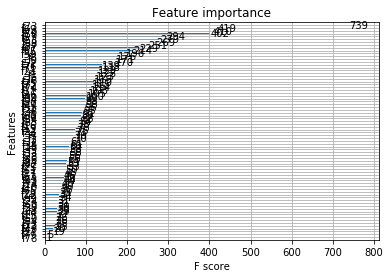

In [10]:
#---------xgboost parameter-------#
"""
params = {
    'booster': 'gbtree',
    'objective': 'multi:softmax',
    'num_class': 5,
    'gamma': 0.1,
    'max_depth': 16,
    'lambda': 2,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3,
    'silent': 1,
    'eta': 0.1,
    'seed': 1000,
    'nthread': 4,
}

plst = params.items()


dtrain = xgb.DMatrix(X_train, y_train)
num_rounds = 1000
model = xgb.train(plst, dtrain, num_rounds)


dtest = xgb.DMatrix(X_test)
ans = model.predict(dtest)

print('ans.shape: ', ans.shape)

ml2.evaluate_model2(ans, y_test)


cnt1 = 0
cnt2 = 0

for i in range(len(y_test)):
    if ans[i] == y_test[i]:
        cnt1 += 1
    else:
        cnt2 += 1

print("Accuracy: %.2f %% " % (100 * cnt1 / (cnt1 + cnt2)))
"""
model = XGBClassifier(learning_rate=0.1,
                        n_estimators=1000,         # 树的个数--1000棵树建立xgboost
                        max_depth=8,               # 树的深度
                        min_child_weight = 1,      # 叶子节点最小权重
                        gamma=0.1,                  # 惩罚项中叶子结点个数前的参数
                        subsample=0.8,             # 随机选择80%样本建立决策树
                        colsample_btree=0.8,       # 随机选择80%特征建立决策树
                        objective='multi:softmax', # 指定损失函数
                        scale_pos_weight=1,        # 解决样本个数不平衡的问题
                        )

model.fit(X_train,y_train)
# 对测试集进行预测
#dtest = xgb.DMatrix(X_test)
#ans = model.predict(dtest)
ans = model.predict(X_test)
print('ans.shape: ', ans.shape)

ml2.evaluate_model2(ans, y_test)

# 计算准确率
cnt1 = 0
cnt2 = 0

for i in range(len(y_test)):
    if ans[i] == y_test[i]:
        cnt1 += 1
    else:
        cnt2 += 1
print("Accuracy: %.2f %% " % (100 * cnt1 / (cnt1 + cnt2)))

plot_importance(model)
plt.show()


In [11]:
#---------------------------K Fold-------------------------------------------#
scoring = ['precision_macro', 'recall_macro']
scores = cross_validate(model, X_train, y_train, scoring=scoring,cv=10, return_train_score=True)
sorted(scores.keys())
print('test result:')
print(scores)
scores_df = pd.DataFrame(scores)

table_header = ['test_recall_macro', 'train_recall_macro','fit_time', 'train_precision_macro','test_precision_macro']

scores_df

test result:
{'fit_time': array([60.68391728, 58.70100331, 51.42715502, 50.93730044, 50.86523986,
       50.90136623, 51.0710783 , 51.13404131, 51.41288137, 50.73938942]), 'test_precision_macro': array([0.99288448, 0.9780093 , 0.98785404, 0.98104573, 0.98772707,
       0.97784298, 0.97248359, 0.99018072, 0.99282498, 0.98032581]), 'train_recall_macro': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), 'test_recall_macro': array([0.99261905, 0.97786005, 0.98756173, 0.98053792, 0.98740428,
       0.97770411, 0.97277097, 0.99017994, 0.99246757, 0.98023788]), 'train_precision_macro': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), 'score_time': array([0.05325937, 0.07225847, 0.04765463, 0.05156708, 0.04966784,
       0.04966259, 0.0499177 , 0.05074811, 0.05204105, 0.05134082])}


,fit_time,score_time,test_precision_macro,test_recall_macro,train_precision_macro,train_recall_macro
0,60.683917,0.053259,0.992884,0.992619,1.0,1.0
1,58.701003,0.072258,0.978009,0.977860,1.0,1.0
2,51.427155,0.047655,0.987854,0.987562,1.0,1.0
3,50.937300,0.051567,0.981046,0.980538,1.0,1.0
4,50.865240,0.049668,0.987727,0.987404,1.0,1.0
5,50.901366,0.049663,0.977843,0.977704,1.0,1.0
6,51.071078,0.049918,0.972484,0.972771,1.0,1.0
7,51.134041,0.050748,0.990181,0.990180,1.0,1.0
8,51.412881,0.052041,0.992825,0.992468,1.0,1.0
9,50.739389,0.051341,0.980326,0.980238,1.0,1.0
